# Tapping mode simulations - 1st eigenmode excited

This notebook contains atomic force microscopy (AFM) dynamic simulations for the case of a tapping mode simulation. Here only the 1st eigenmode is excited. The cantilever dynamics are assumed to be contained in the first three eigenmodes.

The simulations described correspond to dynamic AFM spectroscopy simulations. Here, the cantilever will be brought towards the sample approaching with discrete steps and will be allowed to oscillate until achieving a quasi-steady state. From the tip trajectories and other information recoreded (e.g., tip-sample force, sample position) in the steady state it will be possible to retrieve common information recorded in a dynamic spectroscopy experiment (e.g., amplitude, phase curves).


### Let's first start by importing some useful libraries

In [1]:
from AFM_lib import GenMaxwell_parabolic_LR_niEB
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import pandas as pd
import os
%matplotlib inline

path = os.getcwd()

## First mode results

In [2]:
k_m1 = 5.80
A1, A2, A3 = 350.0e-9, 0.0, 0.0
Q1, Q2, Q3 = 167.0,340.0, 500.0
fo1 = 45.0e3
fo2 = 280.0e3          
fo3 = 17.6*fo1           
k_m2 = 210.0
k_m3 = k_m1*(fo3/fo1)**2
R = 10.0e-9

period1 = 1.0/fo1
period2 = 1.0/fo2

dt = period2/10.0e3
startprint = 5.0*Q1*period1
simultime = startprint + 10.0*period1
printstep = period1/1.0e3

In [3]:
#Sample parameters for polyisobutylene
df_G = pd.read_csv('PIB.txt', delimiter='\t', header=None)
tau = df_G.iloc[:,0].values
G = df_G.iloc[:,1].values
Ge = 0.0
H = 2.0e-19

## Lee & Radok simulation

In [ ]:
os.chdir(path + '/1stMode')
zb = A1
GenMaxwell_jit = jit()(GenMaxwell_parabolic_LR_niEB)
while zb > -100.0e-9:
    %time t, tip, Fts, xb = GenMaxwell_jit(G, tau, R, dt, startprint, simultime, fo1, fo2, fo3, k_m1, k_m2,k_m3, A1, A2, A3, zb, printstep, Ge, Q1, Q2, Q3, H)
    name = str(int(zb*1.0e9)) + '.txt'
    np.savetxt('%s'%name, np.array((t*1.0e6, tip*1.0e9, Fts*1.0e9, xb*1.0e9)).T, delimiter='\t', header = 'time(us)\ttip(nm)\tFts(nN)\tXb(nm)')
    zb = zb - 10.0e-9

## Postprocessing Calculations

In [5]:
from glob import glob
os.chdir(path)
from AFM_calculations import av_dt, Amp_Phase, E_diss, V_ts, Ediss_Tamayo, virial_Lozano

os.chdir(path + '/1stMode')
files = glob('*.txt')

zeq = []
peakF = []
maxdepth = []
amp = []
phase = []
Ediss = []
Ediss_tamayo = []
Vdiss_lozano = []
Vdiss = []

for i in files:
    res = np.loadtxt('%s'%i, skiprows=1)
    t = res[::10,0]*1.0e-6
    dt = av_dt(t)
    
    tip = res[::10,1]*1.0e-9
    A,phi = Amp_Phase(t, tip, fo1)
    Fts = res[::10,2]*1.0e-9
    Ets = E_diss(tip, Fts, dt, fo1)
    fts_peak = Fts[np.argmax(Fts)]
    xb = res[::10,3]*1.0e-9
    tip_depth = xb[np.argmax(tip)] -xb[np.argmin(tip)]
    zb = i.rstrip('.txt')
    Vts = V_ts(tip-float(zb)*1.0e-9, Fts, dt)
    Ets_tamayo = Ediss_Tamayo(k_m1, Q1, A1, A, phi)
    Vts_lozano = virial_Lozano(k_m1, Q1, A1, A, phi)
    
    #Attaching values to arrays
    zeq.append(float(int(zb)))
    peakF.append(fts_peak)
    maxdepth.append(tip_depth)
    amp.append(A)
    phase.append(phi)
    Ediss.append(Ets)
    Vdiss.append(Vts)
    Vdiss_lozano.append(Vts_lozano)
    Ediss_tamayo.append(Ets_tamayo)
    #plt.plot(t, tip)

zeq = np.array(zeq)
peakF= np.array(peakF)
maxdepth = np.array(maxdepth)
amp = np.array(amp)
phase = np.array(phase)
Ediss = np.array(Ediss)
Vdiss = np.array(Vdiss)
Vdiss_lozano = np.array(Vdiss_lozano)
Ediss_tamayo = np.array(Ediss_tamayo)

## Plotting and saving results

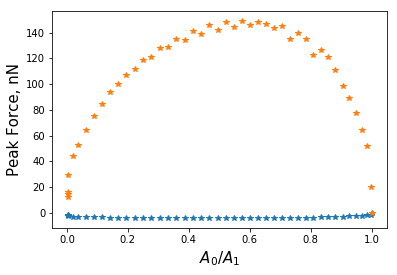

In [6]:
A1 = 350.0e-9   #amplitude of the 1st mode

os.chdir(path + '/1stMode')
plt.figure(1)
plt.plot(amp/A1, -maxdepth*1.0e9, '*')
plt.xlabel('$A_0/A_1$', fontsize =15)
plt.ylabel('Maximum Penetration, nm', fontsize=15)
plt.savefig('Max_penetration.png', bbox_inches='tight')

plt.figure(2)
plt.plot(amp/A1, peakF*1.0e9, '*')
plt.xlabel('$A_0/A_1$', fontsize =15)
plt.ylabel('Peak Force, nN', fontsize=15)
plt.savefig('Max_Force.png', bbox_inches='tight')

z_sort = np.sort(zeq)
index = np.argsort(zeq)
maxd = []
peakforce = []
amplitude = []
Ets = []
phi = []
Vts = []
Vts_lozano = []
Ets_tamayo = []
for i in index:
    maxd.append(maxdepth[i])
    peakforce.append(peakF[i])
    amplitude.append(amp[i])
    Ets.append(Ediss[i])
    phi.append(phase[i])
    Ets_tamayo.append(Ediss_tamayo[i])
    Vts.append(Vdiss[i])
    Vts_lozano.append(Vdiss_lozano[i])

maxd = np.array(maxd)
peakforce = np.array(peakforce)
amplitude = np.array(amplitude)
Ets = np.array(Ets)
phi = np.array(phi)
Ets_tamayo = np.array(Ets_tamayo)
Vts = np.array(Vts)
Vts_lozano = np.array(Vts_lozano)

np.savetxt('1stMode.txt', np.array((amplitude/A1, peakforce*1.0e9, -maxd*1.0e9, phi, Ets*1.0e18, Ets_tamayo*1.0e18, Vts*1.0e18, Vts_lozano*1.0e18 )).T, delimiter='\t', header = 'amp_ratio\tpeakF(nN)\tmaxdepth(nm)\tphase(deg)\tEdiss(aJ)\tEdiss_Tamayo(aJ)\tVts(aJ)\tVts_lozano(aJ)')


## MDR Simulation

In [ ]:
from AFM_lib import MDR_GenMaxwell_tapping

MDR_jit = jit()(MDR_GenMaxwell_tapping)
while zb > -100.0e-9:
    %time t, tip, Fts, xb = MDR_jit(G, tau, R, dt, simultime, zb, A1, k_m1, fo1, printstep, 1000, Ge, 5.0e-9, startprint, Q1, Q2, Q3, H, A2, A3)
    name = str(int(zb*1.0e9)) + '.txt'
    np.savetxt('%s'%name, np.array((t*1.0e6, tip*1.0e9, Fts*1.0e9, xb*1.0e9)).T, delimiter='\t', header = 'time(us)\ttip(nm)\tFts(nN)\tXb(nm)')
    zb = zb - 10.0e-9
